This notebook aims to test out how well the new numerical scheme from Julia is implemented in OGGM

In [1]:
# %%

import oggm
from oggm import cfg, utils, workflow, tasks, graphics, global_tasks
from oggm.core import flowline, massbalance
import salem
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import functools
from oggm.shop import gcm_climate

cfg.initialize(logging_level='WARNING')

cfg.PARAMS['use_multiprocessing'] = False
cfg.PATHS['working_dir'] = '/home/gimenelu/Run_oggm2/'
cfg.PARAMS['continue_on_error'] = True

2023-08-24 15:26:41: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-08-24 15:26:41: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-08-24 15:26:41: oggm.cfg: Multiprocessing: using all available processors (N=16)
2023-08-24 15:26:41: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


In [2]:
rgi_id = ['RGI60-14.07524'] #MdG 03643 #Siachen 14.07524
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5/'
gdirs = workflow.init_glacier_directories(rgi_id, from_prepro_level=4, prepro_base_url=base_url, prepro_border=160)
gdir=gdirs[0]

cfg.PARAMS['use_inversion_params_for_run']= True

workflow.execute_entity_task(tasks.init_present_time_glacier,gdirs);

2023-08-24 15:26:45: oggm.workflow: init_glacier_directories from prepro level 4 on 1 glaciers.
2023-08-24 15:26:45: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2023-08-24 15:26:45: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers


In [12]:
#Climate data to use for later
user ='gimenelu'
m='MRI-ESM2-0'
ssp='ssp126'

fp = '/mnt/{}/equipes/CRYODYN/OGGM/CMIP6/pr/{}_{}_r1i1p1f1_pr.nc'.format(user,m,ssp)
ft = '/mnt/{}/equipes/CRYODYN/OGGM/CMIP6/tas/{}_{}_r1i1p1f1_tas.nc'.format(user,m,ssp)

#Bias correction of the files
workflow.execute_entity_task(gcm_climate.process_cmip_data, gdir, 
                                         filesuffix='_CMIP6_{}_{}'.format(m,ssp),  # recognize the climate file for later
                                         fpath_temp=ft,  # temperature projections
                                         fpath_precip=fp,  # precip projections
                                         );

2023-08-24 15:28:07: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers


## Random climate

In [3]:
cfg.PARAMS["evolution_model"] = "SemiImplicit"

In [4]:
%%time
workflow.execute_entity_task(tasks.run_random_climate,gdirs,y0=2003,nyears=100,seed=1,
                                         output_filesuffix='_semi',
                                        store_model_geometry=True,
                                        store_fl_diagnostics=True)

2023-08-24 15:27:07: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers


CPU times: user 656 ms, sys: 8.03 ms, total: 664 ms
Wall time: 664 ms


In [5]:
ds = utils.compile_run_output(gdirs, input_filesuffix='_semi')

2023-08-24 15:27:09: oggm.utils: Applying global task compile_run_output on 1 glaciers
2023-08-24 15:27:09: oggm.utils: Applying compile_run_output on 1 gdirs.


In [6]:
cfg.PARAMS["evolution_model"] = "SIA1D" 

2023-08-24 15:27:12: oggm.cfg: PARAMS['evolution_model'] changed from `SemiImplicit` to `SIA1D`.


In [ ]:
from juliacall import Main as jl
jl.seval("using OrdinaryDiffEq")
jl.seval("using LinearSolve")
cfg.PARAMS["Julia_solver"] = jl.Rodas5P(linsolve = jl.KrylovJL_GMRES())

In [7]:
cfg.PARAMS["Julia_solver"]

RDPK3Sp35(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))

In [9]:
%%time
workflow.execute_entity_task(tasks.run_random_climate,gdirs,y0=2003,nyears=100,seed=1,
                                         output_filesuffix='_julia',
                                        store_model_geometry=True,
                                        store_fl_diagnostics=True)

2023-08-24 15:27:28: oggm.workflow: Execute entity tasks [run_random_climate] on 1 glaciers


CPU times: user 403 ms, sys: 16 ms, total: 419 ms
Wall time: 418 ms


In [10]:
ds2 = utils.compile_run_output(gdir, input_filesuffix='_julia')

2023-08-24 15:27:31: oggm.utils: Applying global task compile_run_output on 1 glaciers
2023-08-24 15:27:31: oggm.utils: Applying compile_run_output on 1 gdirs.


## Constant climate

In [ ]:
cfg.PARAMS["evolution_model"] = "SemiImplicit"

workflow.execute_entity_task(tasks.run_constant_climate,gdir,y0=1916,nyears=100,
                                         output_filesuffix='_semi',
                                        store_model_geometry=True,
                                        store_fl_diagnostics=True)

ds = utils.compile_run_output(gdir, input_filesuffix='_semi')

In [ ]:
cfg.PARAMS["evolution_model"] = "SIA1D"

workflow.execute_entity_task(tasks.run_constant_climate,gdir,y0=1916,nyears=100,
                                         output_filesuffix='_julia',
                                        store_model_geometry=True,
                                        store_fl_diagnostics=True)

ds2 = utils.compile_run_output(gdir, input_filesuffix='_julia')

## GCM climate data

In [13]:
%%time
cfg.PARAMS["evolution_model"] = "SemiImplicit"        
    
sid = '_CMIP6_{}_{}'.format(m,ssp)
workflow.execute_entity_task(tasks.run_from_climate_data,gdir,ys=2020,
                                         climate_filename='gcm_data',  # use gcm_data, not climate_historical
                                         climate_input_filesuffix=sid,  # use the chosen scenario
                                         output_filesuffix='_semi',
                                         init_model_filesuffix='_historical')
ds = utils.compile_run_output(gdir, input_filesuffix='_semi')

2023-08-24 15:28:46: oggm.cfg: PARAMS['evolution_model'] changed from `SIA1D` to `SemiImplicit`.
2023-08-24 15:28:46: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-24 15:28:47: oggm.utils: Applying global task compile_run_output on 1 glaciers
2023-08-24 15:28:47: oggm.utils: Applying compile_run_output on 1 gdirs.


CPU times: user 640 ms, sys: 0 ns, total: 640 ms
Wall time: 638 ms


In [14]:
%%time
cfg.PARAMS["evolution_model"] = "SIA1D"    
    
sid = '_CMIP6_{}_{}'.format(m,ssp)
workflow.execute_entity_task(tasks.run_from_climate_data,gdir,ys=2020,
                                         climate_filename='gcm_data',  # use gcm_data, not climate_historical
                                         climate_input_filesuffix=sid,  # use the chosen scenario
                                         output_filesuffix='_julia',
                                         init_model_filesuffix='_historical')
ds2 = utils.compile_run_output(gdir, input_filesuffix='_julia')

2023-08-24 15:28:48: oggm.cfg: PARAMS['evolution_model'] changed from `SemiImplicit` to `SIA1D`.
2023-08-24 15:28:48: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2023-08-24 15:28:49: oggm.utils: Applying global task compile_run_output on 1 glaciers
2023-08-24 15:28:49: oggm.utils: Applying compile_run_output on 1 gdirs.


CPU times: user 459 ms, sys: 16.2 ms, total: 475 ms
Wall time: 474 ms


## Testing spinup

### 1. Fixed geometry 

In [ ]:
cfg.PARAMS["evolution_model"] = "SemiImplicit" 

sid = '_CMIP6_{}_{}'.format(m,ssp)
workflow.execute_entity_task(tasks.run_from_climate_data,gdir,fixed_geometry_spinup_yr=1990, ye=2100,
                                         climate_filename='gcm_data',  # use gcm_data, not climate_historical
                                         climate_input_filesuffix=sid,  # use the chosen scenario
                                         output_filesuffix='_hist_fixed_geom',
                                        store_model_geometry=True,
                                        store_fl_diagnostics=True)
# Read the output
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_hist_fixed_geom')) as ds:
    ds = ds.load()

In [ ]:
cfg.PARAMS["evolution_model"] = "SIA1D" 

sid = '_CMIP6_{}_{}'.format(m,ssp)
workflow.execute_entity_task(tasks.run_from_climate_data,gdir,fixed_geometry_spinup_yr=1950, ye=2050,
                                         climate_filename='gcm_data',  # use gcm_data, not climate_historical
                                         climate_input_filesuffix=sid,  # use the chosen scenario
                                         output_filesuffix='_hist_fixed_geom_jl')

# Read the output
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_hist_fixed_geom_jl')) as ds2:
    ds2 = ds2.load()

### 2. Dynamic spinup alone, matching area

In [ ]:
cfg.PARAMS["evolution_model"] = "SemiImplicit" 

In [ ]:
%time
# ---- Second the dynamic spinup alone, matching area ----
workflow.execute_entity_task(tasks.run_dynamic_spinup,gdir,
                         spinup_start_yr=2003,  # When to start the spinup
                         minimise_for='area',  # what target to match at the RGI date
                         output_filesuffix='_spinup_dynamic_area',  # Where to write the output
                         ye=2020)


In [ ]:
# Read the output
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_spinup_dynamic_area')) as ds:
    ds = ds.load()

In [ ]:
cfg.PARAMS["evolution_model"] = "SIA1D" 

In [ ]:
%time
# ---- Second the dynamic spinup alone, matching area ----
workflow.execute_entity_task(tasks.run_dynamic_spinup,gdir,
                         spinup_start_yr=2003,  # When to start the spinup
                         minimise_for='area',  # what target to match at the RGI date
                         output_filesuffix='_spinup_dynamic_area_jl',
                        ye=2020)  # Where to write the output

In [ ]:
# Read the output
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_spinup_dynamic_area_jl')) as ds2:
    ds2 = ds2.load()

### 3. Dynamic spinup alone, matching volume

In [ ]:
%time
cfg.PARAMS["evolution_model"] = "SemiImplicit" 
workflow.execute_entity_task(tasks.run_dynamic_spinup,gdir,
                         spinup_start_yr=1979,  # When to start the spinup
                         minimise_for='volume',  # what target to match at the RGI date
                         output_filesuffix='_spinup_dynamic_volume',  # Where to write the output
                         ye=2020)
# Read the output
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_spinup_dynamic_volume')) as ds:
    ds = ds.load()


In [ ]:
%time
cfg.PARAMS["evolution_model"] = "SIA_1D" 
# ---- Second the dynamic spinup alone, matching area ----
workflow.execute_entity_task(tasks.run_dynamic_spinup,gdir,
                         spinup_start_yr=1979,  # When to start the spinup
                         minimise_for='volume',  # what target to match at the RGI date
                         output_filesuffix='_spinup_dynamic_vol_jl',
                        ye=2020)  # Where to write the output


# Read the output
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_spinup_dynamic_vol_jl')) as ds2:
    ds2 = ds2.load()

In [ ]:
f, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(12, 10),sharex=True)


(ds.volume_m3*1e-9).plot(ax=ax1,label="SemiImplicit")
(ds2.volume_m3*1e-9).plot(ax=ax1,linestyle="dashed",label="SIA_1D")

(ds.area_m2*1e-6).plot(ax=ax2,)
(ds2.area_m2*1e-6).plot(ax=ax2,linestyle='dashed')


(ds.length_m*1e-3).plot(ax=ax3)
(ds2.length_m*1e-3).plot(ax=ax3,linestyle="dashed")

ax1.grid()
ax1.set_ylabel('volume [km3]')
ax1.set_xlabel('')
ax2.grid()
ax2.set_ylabel('area [km2]')
ax2.set_xlabel('')
ax2.set_title('')
ax3.grid()
ax3.set_ylabel('length [km]')
ax3.set_title('')
ax1.legend()

ax1.set_title('Fixed geometry spin-up')

## Testing with hydro

In [16]:
cfg.PARAMS['store_model_geometry'] = True
cfg.PARAMS["evolution_model"] = "SemiImplicit"

sid = '_CMIP6_{}_{}'.format(m,ssp)
workflow.execute_entity_task(tasks.run_with_hydro,gdirs,run_task=tasks.run_from_climate_data,
                                         ys=2020,
                                         climate_filename='gcm_data',  # use gcm_data, not climate_historical
                                         climate_input_filesuffix=sid,  # use the chosen scenario
                                         output_filesuffix='_semi',
                                         store_monthly_hydro=True,
                                         store_model_geometry=True,
                                         store_fl_diagnostics=True,
                                            init_model_filesuffix='_historical');

ds = utils.compile_run_output(gdir, input_filesuffix='_semi')

2023-08-24 15:29:19: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.
2023-08-24 15:29:19: oggm.cfg: PARAMS['evolution_model'] changed from `SIA1D` to `SemiImplicit`.
2023-08-24 15:29:19: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-24 15:29:20: oggm.utils: Applying global task compile_run_output on 1 glaciers
2023-08-24 15:29:20: oggm.utils: Applying compile_run_output on 1 gdirs.


In [17]:
cfg.PARAMS['store_model_geometry'] = True
cfg.PARAMS["evolution_model"] = "SIA1D"

sid = '_CMIP6_{}_{}'.format(m,ssp)
workflow.execute_entity_task(tasks.run_with_hydro,gdirs,run_task=tasks.run_from_climate_data,
                                         ys=2020,
                                         climate_filename='gcm_data',  # use gcm_data, not climate_historical
                                         climate_input_filesuffix=sid,  # use the chosen scenario
                                         output_filesuffix='_julia',
                                         store_monthly_hydro=True, # recognize the run for later
                                        store_model_geometry=True,
                                         store_fl_diagnostics=True,
                            init_model_filesuffix='_historical');

ds2 = utils.compile_run_output(gdir, input_filesuffix='_julia')

2023-08-24 15:29:23: oggm.cfg: PARAMS['evolution_model'] changed from `SemiImplicit` to `SIA1D`.
2023-08-24 15:29:23: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2023-08-24 15:29:24: oggm.utils: Applying global task compile_run_output on 1 glaciers
2023-08-24 15:29:24: oggm.utils: Applying compile_run_output on 1 gdirs.


(2020.0, 2300.0)

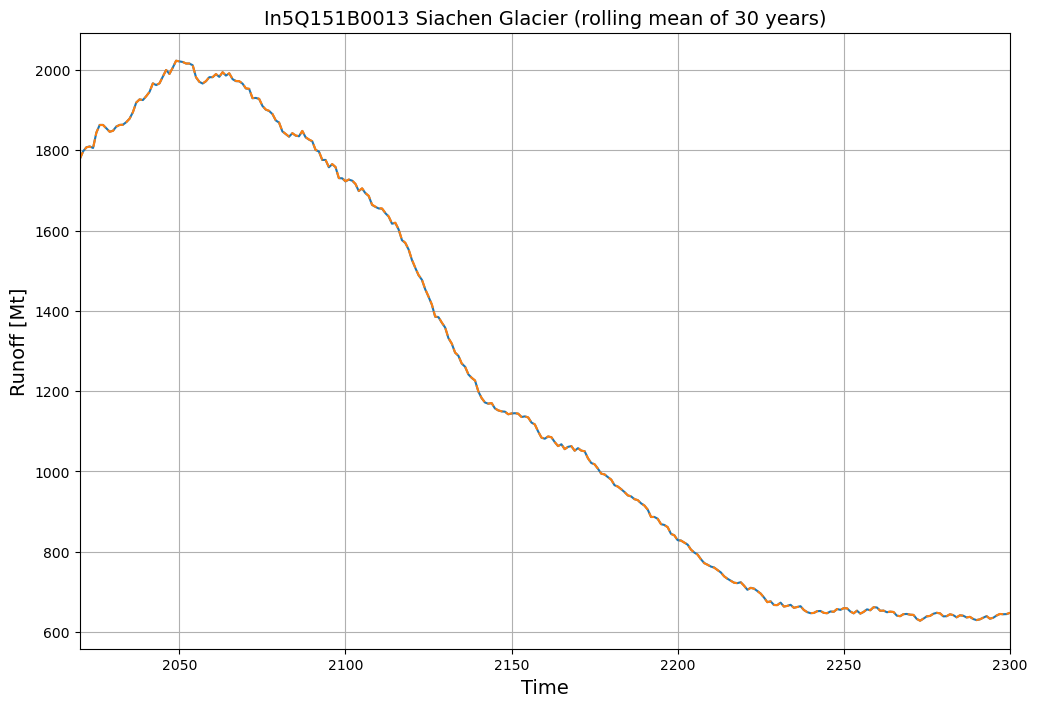

In [18]:
f, (ax1) = plt.subplots(1, 1, figsize=(12, 8),sharex=True)


runoff_vars = ['melt_off_glacier', 'melt_on_glacier','liq_prcp_off_glacier', 'liq_prcp_on_glacier']
ds_runoff = ds[runoff_vars].clip(0) * 1e-9 #convert to Mt
ds_runoff['runoff_Mt']=ds_runoff['melt_on_glacier']+ds_runoff['melt_off_glacier']+ds_runoff['liq_prcp_off_glacier']+ds_runoff['liq_prcp_on_glacier']

ds_runoff['runoff_Mt'].rolling(time=30,center=True,min_periods=1).mean().plot(ax=ax1,label='SemiImplicit')

ds2_runoff = ds2[runoff_vars].clip(0) * 1e-9 #convert to Mt
ds2_runoff['runoff_Mt']=ds2_runoff['melt_on_glacier']+ds2_runoff['melt_off_glacier']+ds2_runoff['liq_prcp_off_glacier']+ds2_runoff['liq_prcp_on_glacier']

ds2_runoff['runoff_Mt'].rolling(time=30,center=True,min_periods=1).mean().plot(ax=ax1,linestyle='dashed',
                                                                               label='Julia')

ax1.set_title(''+gdir.name+' (rolling mean of 30 years)',fontsize=14)

#ax1.set_xlim([2020,2100])
ax1.set_ylabel('Runoff [Mt]',fontsize=14)
ax1.set_xlabel('Time',fontsize=14)
ax1.grid(visible=True)
ax1.set_xlim([2020,2300])

# Plotting results of climate simulation (random, constant or GCM data)

Text(0.5, 1.0, 'Simulation based on GCM climate data')

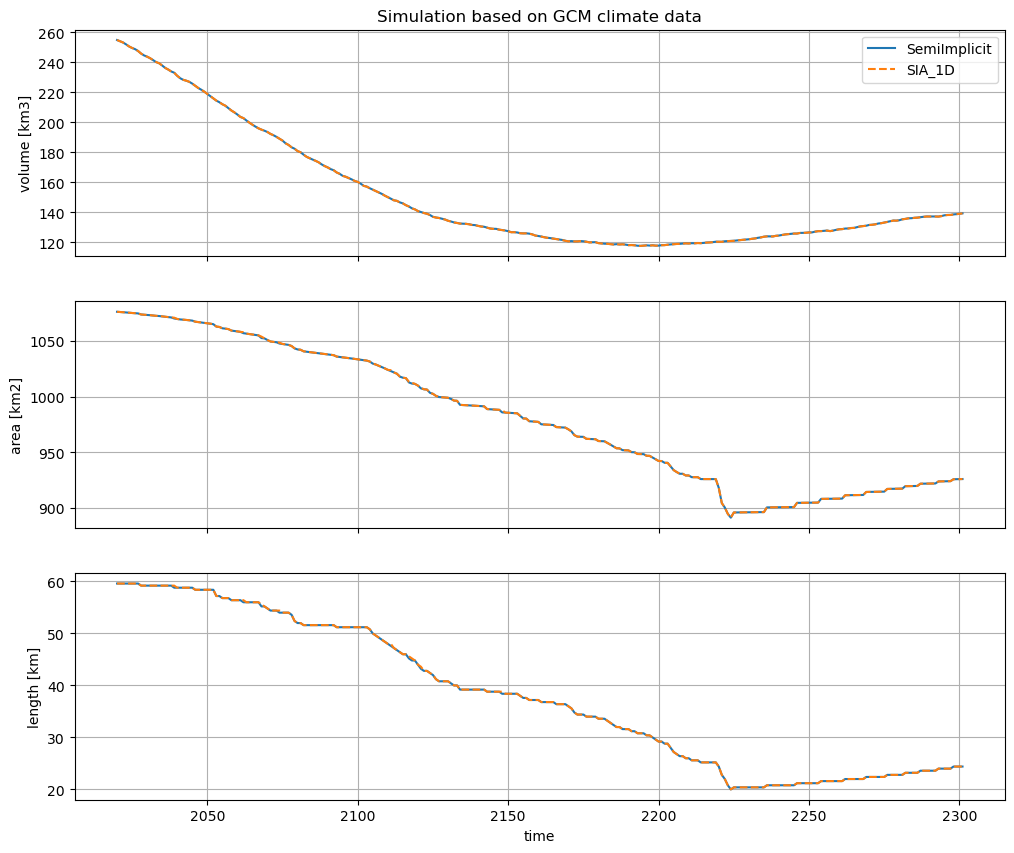

In [15]:
f, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(12, 10),sharex=True)

(ds.volume*1e-9).plot(ax=ax1,label="SemiImplicit")
(ds2.volume*1e-9).plot(ax=ax1,linestyle="dashed",label="SIA_1D")

(ds.area*1e-6).plot(ax=ax2)
(ds2.area*1e-6).plot(ax=ax2,linestyle='dashed')


(ds.length*1e-3).plot(ax=ax3)
(ds2.length*1e-3).plot(ax=ax3,linestyle="dashed")

ax1.grid()
ax1.set_ylabel('volume [km3]')
ax1.set_xlabel('')
ax2.grid()
ax2.set_ylabel('area [km2]')
ax2.set_xlabel('')
ax2.set_title('')
ax3.grid()
ax3.set_ylabel('length [km]')
ax3.set_title('')
ax1.legend()
#ax1.set_xlim([2020,2100])
ax1.set_title('Simulation based on GCM climate data')

# Checking the geometry files

In [19]:
with xr.open_dataset(gdir.get_filepath('model_geometry',filesuffix='_julia'),group="fl_0") as dj:
    dj = dj.load()
with xr.open_dataset(gdir.get_filepath('model_geometry',filesuffix='_semi'),group="fl_0") as do:
    do = do.load()

In [20]:
with xr.open_dataset(gdir.get_filepath('fl_diagnostics',filesuffix='_semi'),group="fl_0") as flj:
    flj = flj.load()
with xr.open_dataset(gdir.get_filepath('fl_diagnostics',filesuffix='_julia'),group="fl_0") as flo:
    flo = flo.load()

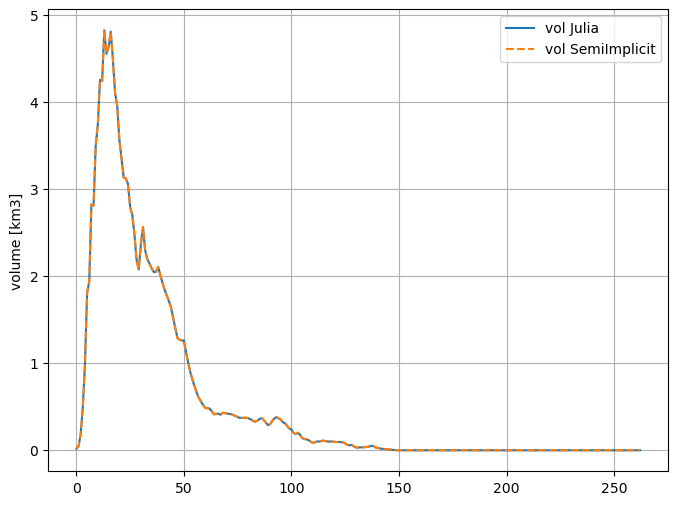

In [21]:
f= plt.subplots(figsize=(8, 6))

plt.plot(flj.mean(dim="time").volume_m3*1e-9 ,label='vol Julia')
plt.plot(flo.mean(dim="time").volume_m3*1e-9,linestyle='dashed',label='vol SemiImplicit')
plt.ylabel('volume [km3]')

plt.grid()
plt.legend()

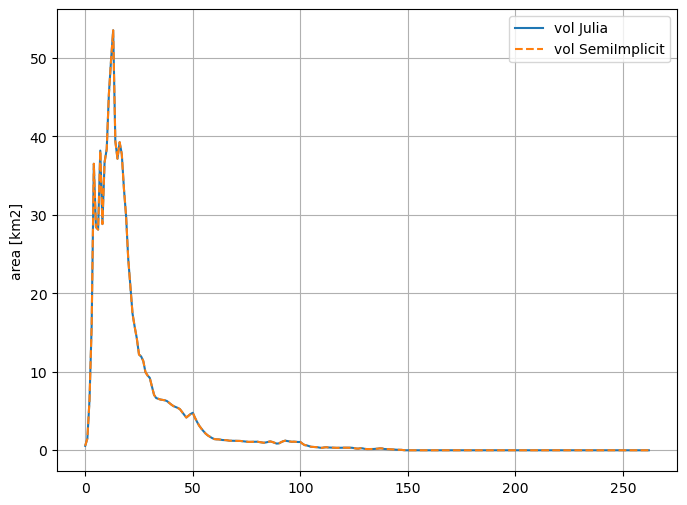

In [22]:
f= plt.subplots(figsize=(8, 6))

plt.plot(flj.mean(dim="time").area_m2*1e-6 ,label='vol Julia')
plt.plot(flo.mean(dim="time").area_m2*1e-6,linestyle='dashed',label='vol SemiImplicit')
plt.ylabel('area [km2]')


plt.grid()
plt.legend()

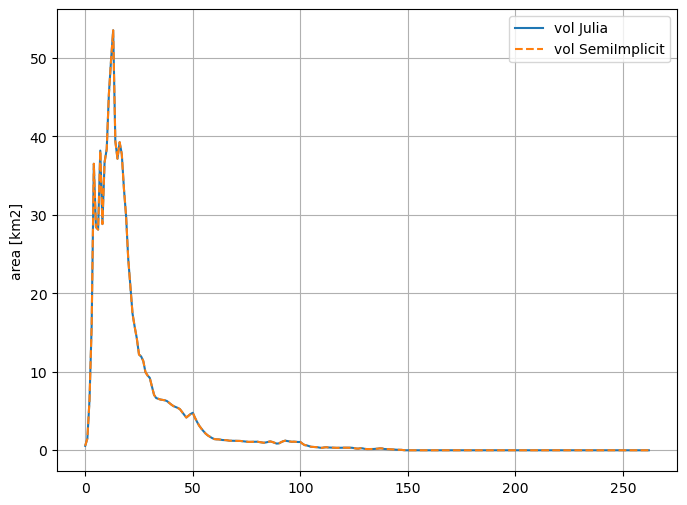

In [23]:
f= plt.subplots(figsize=(8, 6))

plt.plot(flj.mean(dim="time").area_m2*1e-6 ,label='vol Julia')
plt.plot(flo.mean(dim="time").area_m2*1e-6,linestyle='dashed',label='vol SemiImplicit')
plt.ylabel('area [km2]')


plt.grid()
plt.legend()

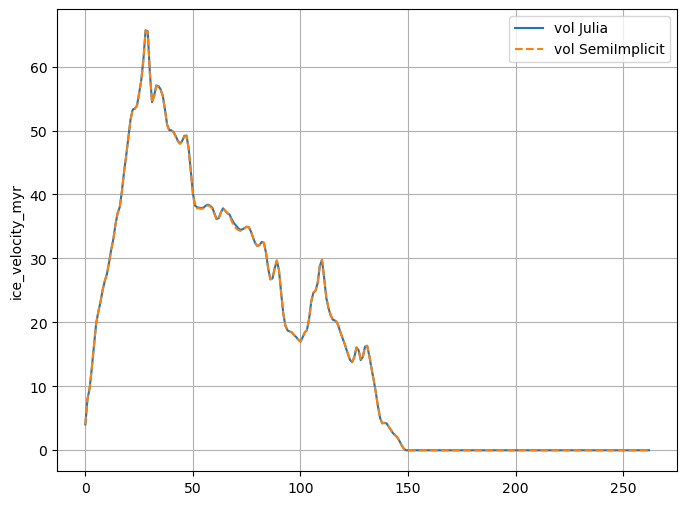

In [24]:
f= plt.subplots(figsize=(8, 6))

plt.plot(flj.mean(dim="time").ice_velocity_myr ,label='vol Julia')
plt.plot(flo.mean(dim="time").ice_velocity_myr,linestyle='dashed',label='vol SemiImplicit')
plt.ylabel('ice_velocity_myr')


plt.grid()
plt.legend()

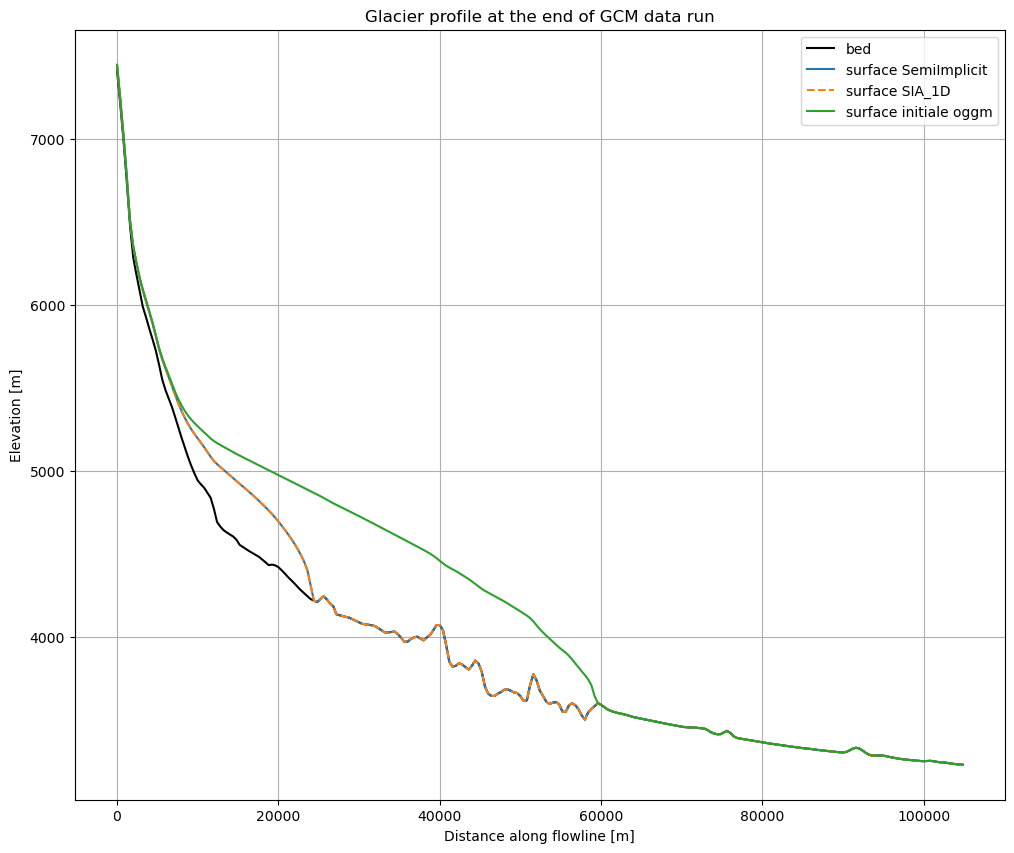

In [25]:
f= plt.subplots(figsize=(12, 10))


plt.plot(flj.dis_along_flowline,flj.bed_h,label='bed',color='k')
plt.plot(flo.dis_along_flowline,flo.bed_h + flo.thickness_m[-1] ,label='surface SemiImplicit')
plt.plot(flj.dis_along_flowline,flj.bed_h + flj.thickness_m[-1] ,label='surface SIA_1D', linestyle='dashed')


plt.plot(flo.dis_along_flowline,flo.bed_h + flo.thickness_m[0] ,label='surface initiale oggm')
plt.ylabel('Elevation [m]')
plt.xlabel('Distance along flowline [m]')
plt.title('Glacier profile at the end of GCM data run')

plt.grid()
plt.legend()


In [26]:
np.mean((dj.mean(dim="x").ts_section - do.mean(dim="x").ts_section)*1e-6)

<xarray.DataArray 'ts_section' ()>
array(-0.00025882)

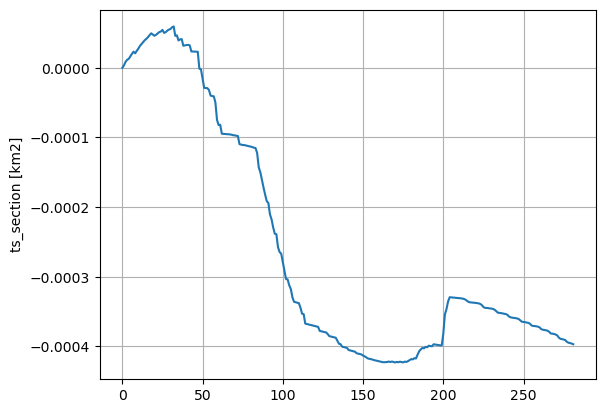

In [27]:
plt.plot((dj.mean(dim="x").ts_section - do.mean(dim="x").ts_section)*1e-6)
plt.ylabel('ts_section [km2]')
plt.grid()

In [28]:
np.mean((dj.mean(dim="x").ts_width_m - do.mean(dim="x").ts_width_m)*1e-3)

<xarray.DataArray 'ts_width_m' ()>
array(1.68854317e-05)

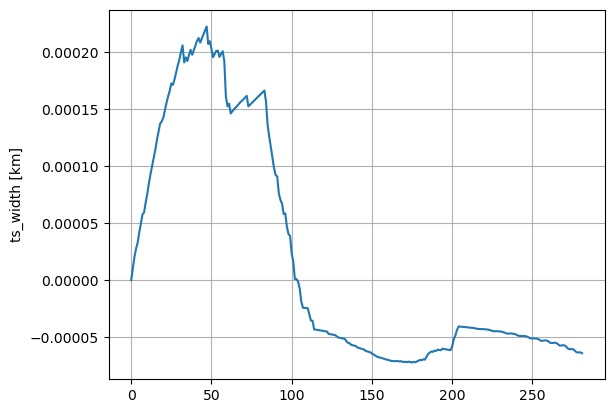

In [29]:
plt.plot((dj.mean(dim="x").ts_width_m - do.mean(dim="x").ts_width_m)*1e-3)
plt.ylabel('ts_width [km]')
plt.grid()

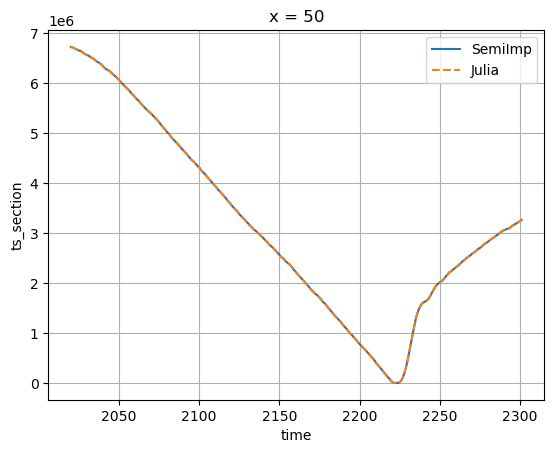

In [30]:
do.isel(x=50).ts_section.plot(label='SemiImp')
dj.isel(x=50).ts_section.plot(label='Julia',linestyle='dashed')
plt.legend()
plt.grid()

In [ ]:
do.isel(x=100).ts_width_m.plot(label='SemiImp')
dj.isel(x=100).ts_width_m.plot(label='Julia',linestyle='dashed')
plt.legend()
plt.grid()